In [37]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
import cv2
import os
import albumentations as A
from tensorflow.python.client import device_lib
# GPU 인식 되었는지 확인
if not tf.config.list_physical_devices('GPU'):
    print('GPU is not detected!!!')
else:
    print('GPU detected!!!\n')
    print('Device type list:')
    print(device_lib.list_local_devices())

GPU detected!!!

Device type list:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14751876649955645907
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4850712576
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12857538786834981212
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [38]:
# 데이터 받기
import hub
data_train = hub.load("hub://activeloop/LFPW-train").tensorflow()
data_test = hub.load("hub://activeloop/LFPW-test").tensorflow()

hub://activeloop/LFPW-train loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/LFPW-train
hub://activeloop/LFPW-test loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/LFPW-test


tf.Tensor([178], shape=(1,), dtype=int32)
tf.Tensor([184], shape=(1,), dtype=int32)
tf.Tensor([193], shape=(1,), dtype=int32)
tf.Tensor([200], shape=(1,), dtype=int32)
tf.Tensor([192], shape=(1,), dtype=int32)
tf.Tensor([183], shape=(1,), dtype=int32)
tf.Tensor([235], shape=(1,), dtype=int32)
tf.Tensor([243], shape=(1,), dtype=int32)
tf.Tensor([251], shape=(1,), dtype=int32)
tf.Tensor([259], shape=(1,), dtype=int32)
tf.Tensor([252], shape=(1,), dtype=int32)
tf.Tensor([244], shape=(1,), dtype=int32)


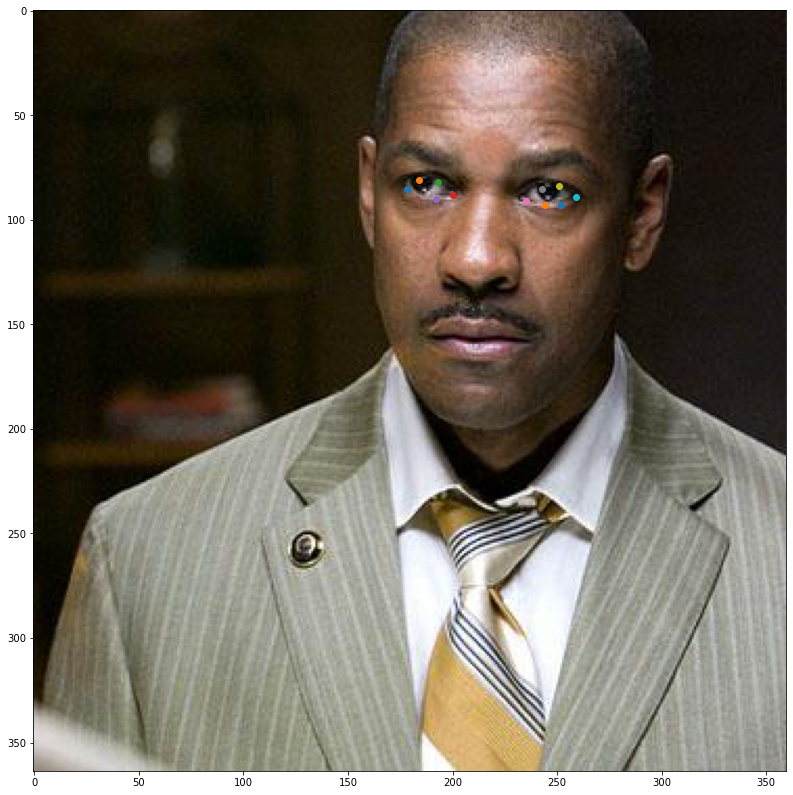

In [39]:
# 받은 데이터셋이 잘 나오는지 확인
fig, ax = plt.subplots(figsize=(14, 14))
for i in data_train:
    ax.imshow(i["images"])
    index=0
    for j in range(0, len(i["keypoints"]), 3):
        index+=1
        if index > 36 and index < 49:
            print(i["keypoints"][j])
            ax.scatter(i["keypoints"][j],i["keypoints"][j+1])
    break

In [40]:
path = "D:LFPW/"
if (path + "/train_image.npy") == False:
    
    #데이터 저장할 폴더 생성(위치 : path)
    os.makedirs(path)
    
    # images쪽만 수집
    train_images = []
    test_images = []
    # keypoints쪽만 수집
    train_annotation = []
    test_annotation = []

    # data_train부분 데이터 전처리
    for i in data_train:
        train_image = np.array(i["images"])
    #     image == color일때만 list에 저장
        if i["images"].shape[2] !=3:
            continue
        train_images.append(train_image)
    #     keypoints쪽 list에 저장
        train_annotation.append(np.array(i["keypoints"]))
    print("Train convert done")

    # data_test부분 데이터 전처리
    # 위와 동일
    for i in data_test:
        test_image = np.array(i["images"])
        test_images.append(test_image)
        test_annotation.append(np.array(i["keypoints"]))
    print("Test convert done")
    
    fig, ax = plt.subplots(1, 4, figsize=(22, 5))
    for i in range(4):
        index = np.random.randint(500)
        ax[i].imshow(train_images[index])
        ax[i].set_title("{}th sample in train set".format(index))
        ax[i].xaxis.set_ticks([])
        ax[i].yaxis.set_ticks([])
        
    # train, test저장(images, keypoints 분리해서)
    np.save("D:LFPW/train_image.npy", train_images)
    np.save("D:LFPW/train_annotation.npy", train_annotation)
    np.save("D:LFPW/test_image.npy", test_images)
    np.save("D:LFPW/test_annotation.npy", test_annotation)
    
    # images가 잘 저장되어있는지 확인
    load = np.load("D:LFPW/train_image.npy",allow_pickle=True)
    
    fig, ax = plt.subplots(1, 4, figsize=(22, 5))
    for i in range(4):
        index = np.random.randint(500)
        ax[i].imshow(load[index])
        ax[i].set_title("{}th sample in train set".format(index))
        ax[i].xaxis.set_ticks([])
        ax[i].yaxis.set_ticks([]) 

In [41]:
# 이미지 load
train_image_orgin = np.load(os.path.join(path,"train_image.npy"), allow_pickle=True)
train_annotation_orgin = np.load(os.path.join(path,"train_annotation.npy"), allow_pickle=True)
test_image_orgin = np.load(os.path.join(path,"test_image.npy"), allow_pickle=True)
test_annotation_orgin = np.load(os.path.join(path,"test_annotation.npy"), allow_pickle=True)

In [42]:
# 원본 복사(원본을 잘못 건들면 20분이 넘게 날아간다....)
train_image = train_image_orgin.copy()
train_annotation = train_annotation_orgin.copy()
test_image = test_image_orgin.copy()
test_annotation = test_annotation_orgin.copy()

In [52]:
# keypoints들 중 눈만 뽑기
train_keypoint = []
for i in train_annotation:
    index = 0
    for j in range(0, len(train_annotation), 3):
        index+=1
        if index > 36 and index < 49:
            train_keypoint.append([i[j], i[j+1]])

train_keypoint = np.reshape(train_keypoint, (len(train_annotation), 12, 2))

In [53]:
# 위와 동일
test_keypoint = []
for i in test_annotation:
    index=0
    for j in range(0, len(test_annotation), 3):
        index+=1
        if index > 36 and index < 49:
            test_keypoint.append([i[j], i[j+1]])

test_keypoint = np.reshape(test_keypoint, (len(test_annotation), 12, 2))

In [439]:
# 데이터 증강
# image size = 80 -> 이후 변환 가능
import random
def train_transform(random1, random2, random3, image = train_image, keypoints = train_keypoint):
    image_tr = []
    keypoint_tr = []
    image_tr = image
    keypoint_tr = keypoints
    
    transform_crop = A.Compose([
        A.Resize(200, 200, interpolation=cv2.INTER_AREA),
        A.RandomCrop(160, 160),
        A.HorizontalFlip(p=1),
    #     A.ChannelDropout(always_apply=False, p=1.0, channel_drop_range=(1, 1), fill_value=random.randrange(0,256)),
#         A.ChannelShuffle(always_apply=False, p=1.0),
        A.RGBShift (r_shift_limit=random3, g_shift_limit=random3, b_shift_limit=random3, always_apply=False, p=0.5),
        A.CLAHE(always_apply=False, p=1.0, clip_limit=(1, 4), tile_grid_size=(8, 8)),
        A.Cutout(num_holes=random1, max_h_size=random2, max_w_size=random2,p=1),
        A.RandomBrightnessContrast(brightness_limit=(-0.5, 0.5), contrast_limit=[-0.5, 0.5], brightness_by_max=False)
    ], keypoint_params=A.KeypointParams(format="xy", remove_invisible=False))
    
    transformed = transform_crop(image = image_tr, keypoints = keypoint_tr)
    
    return transformed

1. cv2.INTER_NEAREST - 최근방 이웃 보간법

 가장 빠르지만 퀄리티가 많이 떨어집니다. 따라서 잘 쓰이지 않습니다.

 

2. cv2.INTER_LINEAR - 양선형 보간법(2x2 이웃 픽셀 참조)

 4개의 픽셀을 이용합니다.

 효율성이 가장 좋습니다. 속도도 빠르고 퀄리티도 적당합니다.

 

3. cv2.INTER_CUBIC - 3차회선 보간법(4x4 이웃 픽셀 참조)

 16개의 픽셀을 이용합니다.

 cv2.INTER_LINEAR 보다 느리지만 퀄리티는 더 좋습니다.

 

4. cv2.INTER_LANCZOS4 - Lanczos 보간법 (8x8 이웃 픽셀 참조)

 64개의 픽셀을 이용합니다.

 좀더 복잡해서 오래 걸리지만 퀄리티는 좋습니다.

 

5. cv2.INTER_AREA - 영상 축소시 효과적

 영역적인 정보를 추출해서 결과 영상을 셋팅합니다.

 영상을 축소할 때 이용합니다.

In [440]:
transform_resize = A.Compose([
    A.Resize(160, 160, interpolation=cv2.INTER_AREA),
], keypoint_params=A.KeypointParams(format="xy", remove_invisible=False))

In [441]:
X_train = []
y_train = []
for index in range(5):
    for i in range(len(train_image)):
#         transformed = transform_crop(image = train_image[i], keypoints = train_keypoint[i])
        transformed = train_transform(random.randrange(2,8), random.randrange(10,40), random.randrange(5,25), train_image[i], train_keypoint[i])
        X_train.append(transformed["image"])
        y_train.append(transformed["keypoints"])

In [442]:
X_test = []
y_test = []
for i in range(len(test_image)):
    transformed = transform_resize(image = test_image[i], keypoints = test_keypoint[i])
    X_test.append(transformed["image"])
    y_test.append(transformed["keypoints"])

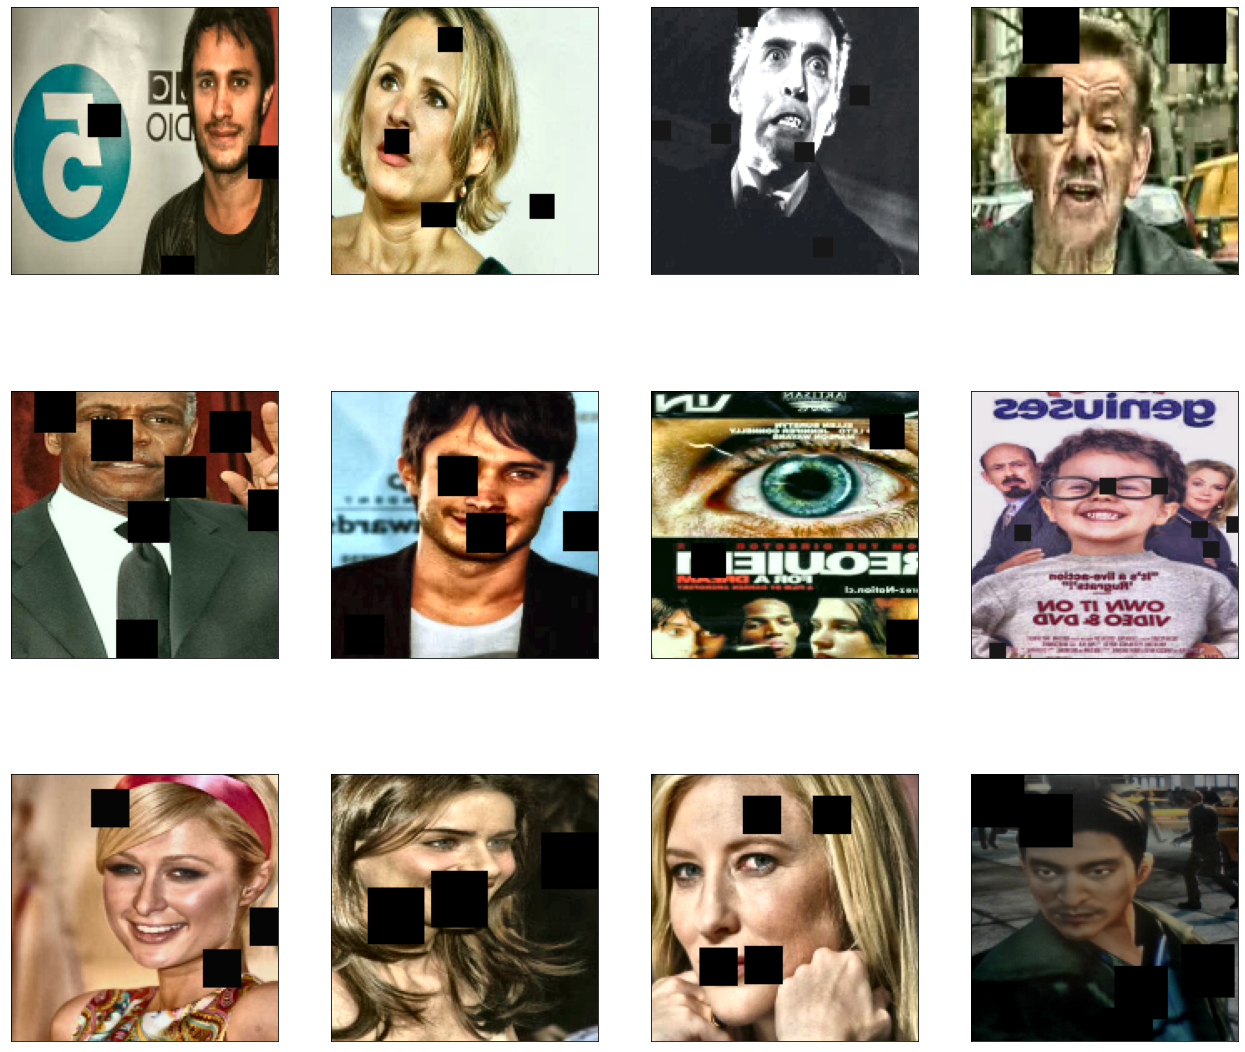

In [443]:
fig, ax = plt.subplots(3, 4, figsize=(22, 20))
for i in range(12):
    j = i//4
    k = i%4
    index = np.random.randint(len(dataset))
    ax[j][k].imshow(X_train[index])
    ax[j][k].xaxis.set_ticks([])
    ax[j][k].yaxis.set_ticks([])

In [444]:
X_train = np.array(X_train) 
y_train = np.reshape(y_train, (X_train.shape[0], 24))
X_test = np.array(X_test) 
y_test = np.reshape(y_test, (X_test.shape[0], 24))

In [445]:
def make2_model():
    model = keras.applications.resnet.ResNet50(include_top = False, weights = 'imagenet', input_shape=(size, size, 3))
    x = model.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(1024, activation="relu",kernel_initializer="he_normal")(x)
    x = keras.layers.Dense(512, activation="relu",kernel_initializer="he_normal")(x)
    x = keras.layers.Dense(256, activation="relu",kernel_initializer="he_normal")(x)
    x = keras.layers.Dense(128, activation="relu",kernel_initializer="he_normal")(x)
    x = keras.layers.Dense(24, activation="linear")(x)
    model = keras.Model(model.input, x)
    return model

In [446]:
transfer_model = keras.applications.EfficientNetB0(weights="imagenet",
                                                   include_top=False,
                                                   input_shape=(X_train.shape[1],
                                                                X_train.shape[2], 3),)
x = transfer_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
predictions = keras.layers.Dense(24, activation="linear",
                                 kernel_initializer="he_normal")(x)


model = keras.Model(inputs=transfer_model.input, outputs=predictions)

In [447]:
for layer in transfer_model.layers:
    layer.trainable = False

In [448]:
model.compile(loss="mse", optimizer="adam", metrics="mse")
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=5)

Epoch 1/5
123/123 [==============================] - 15s 65ms/step - loss: 4170.9292 - mse: 4170.9292 - val_loss: 3877.2837 - val_mse: 3877.2837
Epoch 2/5
123/123 [==============================] - 7s 56ms/step - loss: 2556.4797 - mse: 2556.4797 - val_loss: 2867.7700 - val_mse: 2867.7700
Epoch 3/5
123/123 [==============================] - 7s 56ms/step - loss: 1687.8949 - mse: 1687.8949 - val_loss: 2223.0371 - val_mse: 2223.0371
Epoch 4/5
123/123 [==============================] - 7s 56ms/step - loss: 1239.9314 - mse: 1239.9314 - val_loss: 1820.4797 - val_mse: 1820.4797
Epoch 5/5
123/123 [==============================] - 7s 57ms/step - loss: 1011.3892 - mse: 1011.3892 - val_loss: 1577.6254 - val_mse: 1577.6254


In [449]:
for layer in model.layers:
   layer.trainable = True

In [450]:
model_temp = keras.models.clone_model(model)

In [451]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3,
                                             min_lr=0.0001, verbose=1, mode='min')
ES = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode = 'min')

In [452]:
model.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics="mse")
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=100,
         callbacks=[reduce_lr, ES])

Epoch 1/100
123/123 [==============================] - 37s 248ms/step - loss: 576.2991 - mse: 576.2991 - val_loss: 1734.7834 - val_mse: 1734.7834 - lr: 0.0010
Epoch 2/100
123/123 [==============================] - 29s 235ms/step - loss: 162.7951 - mse: 162.7951 - val_loss: 884.6186 - val_mse: 884.6186 - lr: 0.0010
Epoch 3/100
123/123 [==============================] - 29s 238ms/step - loss: 89.3941 - mse: 89.3941 - val_loss: 578.7740 - val_mse: 578.7740 - lr: 0.0010
Epoch 4/100
123/123 [==============================] - 30s 240ms/step - loss: 63.5482 - mse: 63.5482 - val_loss: 755.4359 - val_mse: 755.4359 - lr: 0.0010
Epoch 5/100
123/123 [==============================] - 30s 243ms/step - loss: 46.8350 - mse: 46.8350 - val_loss: 556.1447 - val_mse: 556.1447 - lr: 0.0010
Epoch 6/100
123/123 [==============================] - 30s 244ms/step - loss: 39.4961 - mse: 39.4961 - val_loss: 570.5982 - val_mse: 570.5982 - lr: 0.0010
Epoch 7/100
123/123 [==============================] - 30s 243ms

1/1 [==============================] - 1s 1s/step
[[98.2523   59.948044 95.02911  57.369934 90.68391  57.47771  87.048676
  60.256393 90.817764 61.423325 95.02921  61.59666  68.4372   59.972504
  65.19768  57.041138 60.93514  56.770206 57.241283 58.990757 60.194088
  60.600758 64.48792  60.858494]]


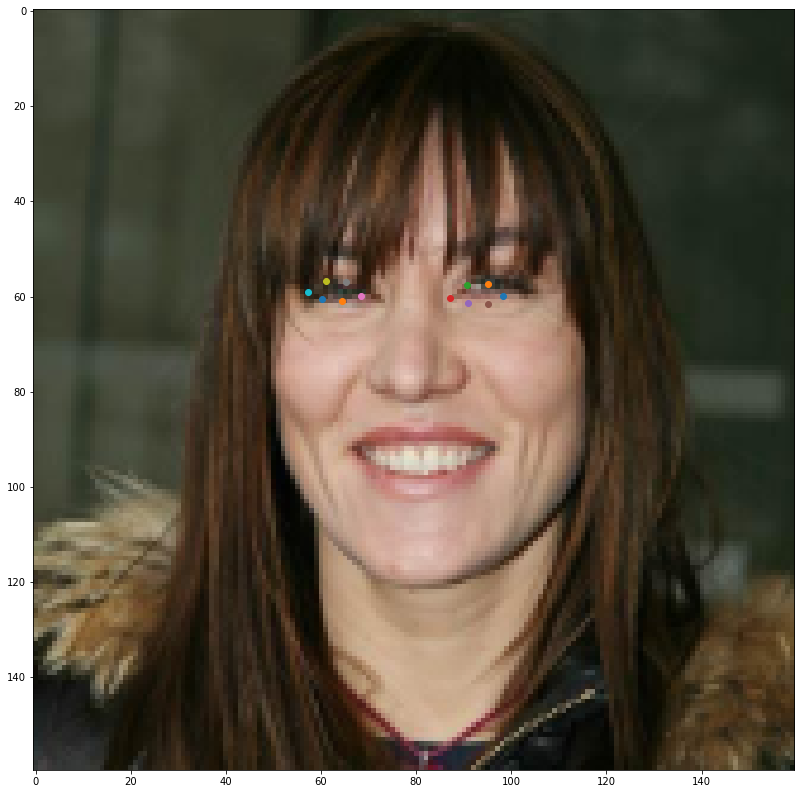

In [453]:
index = 5
fig, ax = plt.subplots(figsize=(14, 14))
pred = model.predict(np.array([X_test[index]]))
ax.imshow(X_test[index])
for j in range(0, 24, 2):
    ax.scatter(pred[0][j], pred[0][j + 1])
print(pred)

1/1 [==============================] - 0s 21ms/step


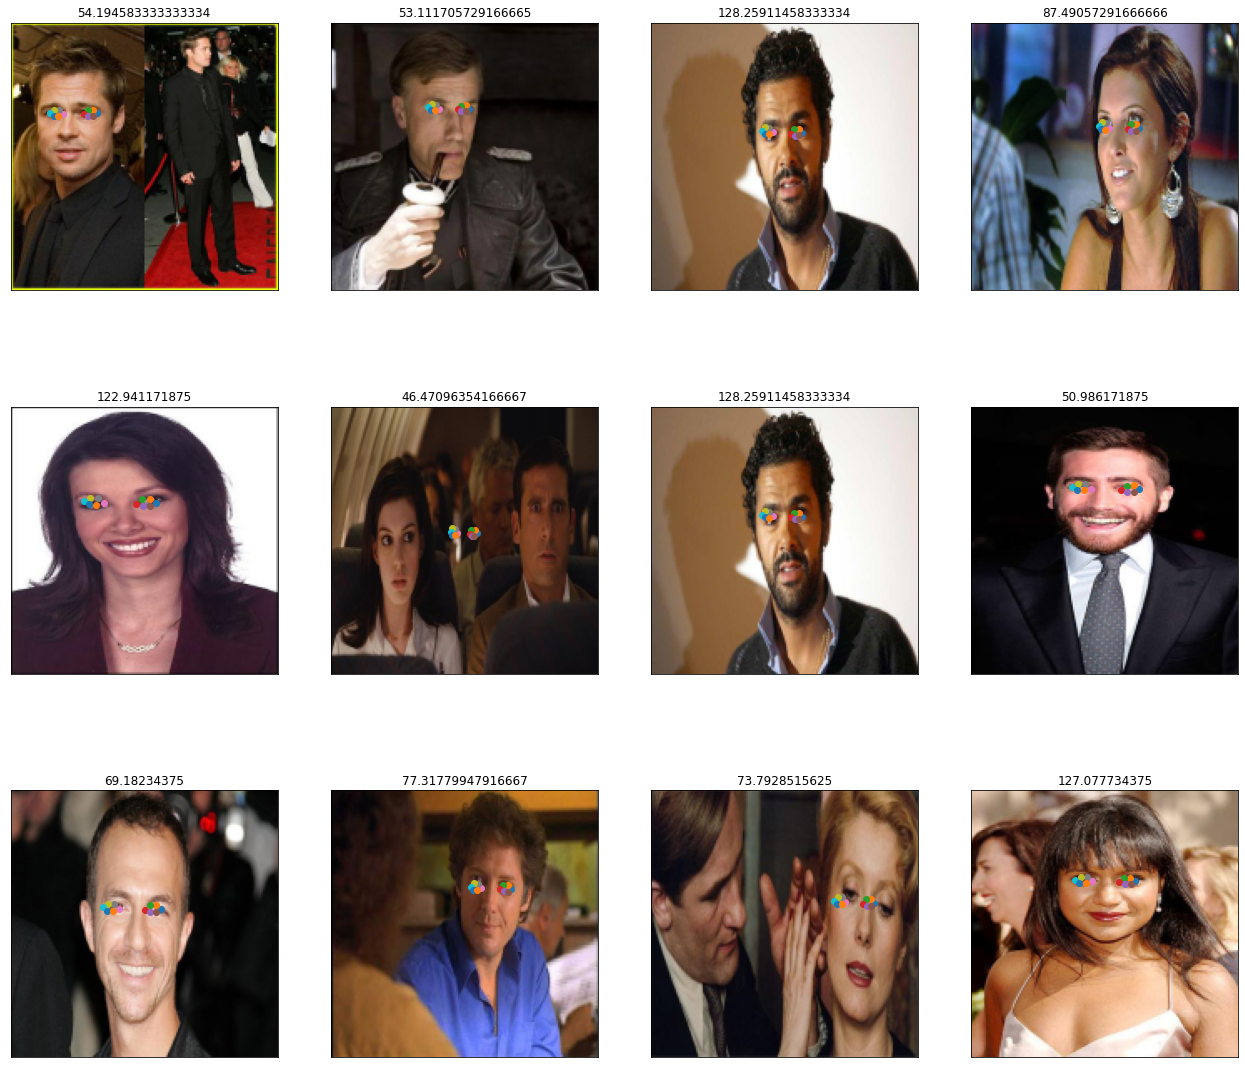

In [454]:
fig, ax = plt.subplots(3, 4, figsize=(22, 20))
for i in range(12):
    j = i//4
    k = i%4
    index = np.random.randint(len(dataset))
    pred = model.predict(np.array([X_test[index]]))[0]
    ax[j][k].imshow(X_test[index])
    ax[j][k].set_title(X_test[index].mean())
    ax[j][k].xaxis.set_ticks([])
    ax[j][k].yaxis.set_ticks([])   
    for i in range(0, 24, 2):
        ax[j][k].scatter(pred[i], pred[i+1])

In [486]:
import math
def eye_distance(pred):
    dist_left = math.sqrt((pred[0] - pred[6])**2 + (pred[1] - pred[7])**2)
    dist_left_ver = (math.sqrt((pred[2] - pred[10])**2 + (pred[3] - pred[11])**2) + math.sqrt((pred[4] - pred[8])**2 + (pred[5] - pred[9])**2)) / 2
    left_eye = dist_left_ver / dist_left
    
    dist_right = math.sqrt((pred[12] - pred[18])**2 + (pred[13] - pred[19])**2)
    dist_right_ver = (math.sqrt((pred[14] - pred[22])**2 + (pred[15] - pred[23])**2) + math.sqrt((pred[16] - pred[20])**2 + (pred[17] - pred[21])**2)) / 2
    right_eye = dist_right_ver / dist_right
    
    dist = (left_eye + right_eye) / 2
    return dist

In [495]:
def sleep_detection(pred):
    dist = eye_distance(pred)
    if dist >= 0.25:
        sleep = 'False'
    else:
        sleep = 'True'
    return dist, sleep

In [496]:
pred = model.predict(np.array([X_test[0]]))[0]
dist, sleep_detect = sleep_detection(pred)
print(dist, sleep_detect)

1/1 [==============================] - 0s 24ms/step
0.3093823502741845 False


1/1 [==============================] - 0s 21ms/step
0.4822229361724898 False
1/1 [==============================] - 0s 22ms/step
0.3629743109599324 False
1/1 [==============================] - 0s 22ms/step
0.3315109021282098 False
1/1 [==============================] - 0s 22ms/step
0.4748698920859009 False
1/1 [==============================] - 0s 22ms/step
0.37394307929054016 False
1/1 [==============================] - 0s 23ms/step
0.5091001785526972 False
1/1 [==============================] - 0s 24ms/step
0.33606676110478345 False
1/1 [==============================] - 0s 22ms/step
0.3251323889775508 False
1/1 [==============================] - 0s 21ms/step
0.4908270450067683 False
1/1 [==============================] - 0s 22ms/step
0.3289632581142569 False
1/1 [==============================] - 0s 23ms/step
0.31020819125668214 False
1/1 [==============================] - 0s 22ms/step
0.3482941710235231 False


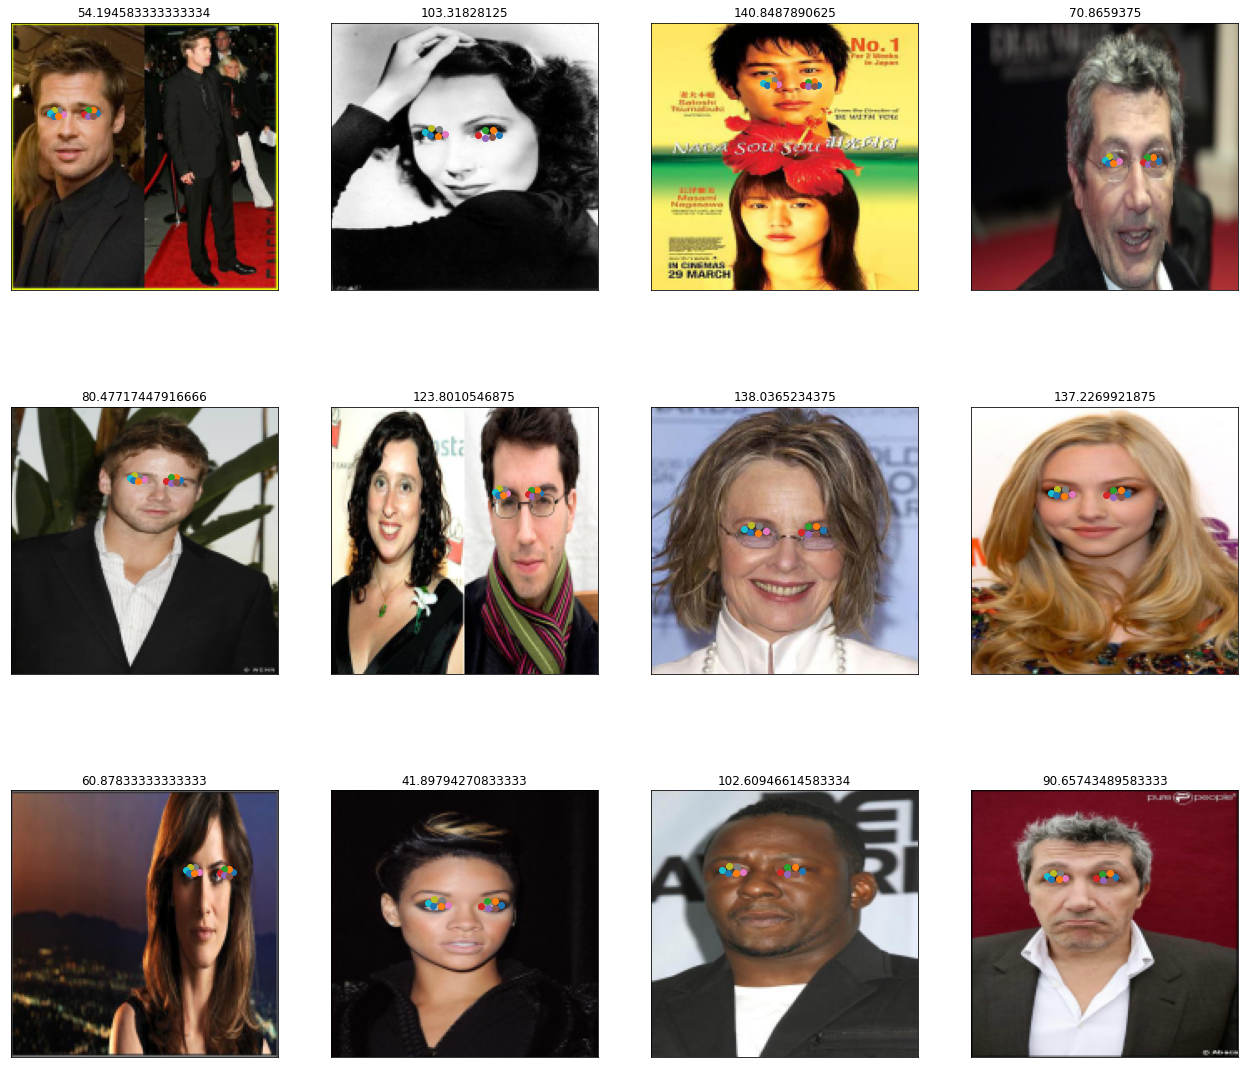

In [498]:
fig, ax = plt.subplots(3, 4, figsize=(22, 20))
for i in range(12):
    j = i//4
    k = i%4
    index = np.random.randint(len(dataset))
    pred = model.predict(np.array([X_test[index]]))[0]
    ax[j][k].imshow(X_test[index])
    ax[j][k].set_title(X_test[index].mean())
    ax[j][k].xaxis.set_ticks([])
    ax[j][k].yaxis.set_ticks([])
    dist, sleep = sleep_detection(pred)
    print(dist, sleep)
    for i in range(0, 24, 2):
        ax[j][k].scatter(pred[i], pred[i+1])

In [499]:
model.save('./model.h5')

In [500]:
for i in range(0, len(X_test)):
    pred = model.predict(np.array([X_test[i]]))[0]
    dist, sleep = sleep_detection(pred)
    print(dist, sleep)

1/1 [==============================] - 0s 23ms/step
0.3093823502741845 False
1/1 [==============================] - 0s 22ms/step
0.3521556485350187 False
1/1 [==============================] - 0s 22ms/step
0.4822229361724898 False
1/1 [==============================] - 0s 22ms/step
0.5477335774070042 False
1/1 [==============================] - 0s 23ms/step
0.32601606994320764 False
1/1 [==============================] - 0s 23ms/step
0.3554976948024522 False
1/1 [==============================] - 0s 23ms/step
0.46746181310637136 False
1/1 [==============================] - 0s 23ms/step
0.3965870099024863 False
1/1 [==============================] - 0s 22ms/step
0.5387140747546764 False
1/1 [==============================] - 0s 22ms/step
0.4355583720024699 False
1/1 [==============================] - 0s 23ms/step
0.7378010274962767 False
1/1 [==============================] - 0s 23ms/step
0.4319493420068297 False
1/1 [==============================] - 0s 23ms/step
0.3547112986883607 Fal

1/1 [==============================] - 0s 27ms/step
0.6176194151092802 False
1/1 [==============================] - 0s 21ms/step
0.49841510606064415 False
1/1 [==============================] - 0s 21ms/step
0.3289632581142569 False
1/1 [==============================] - 0s 22ms/step
0.44058011657541063 False
1/1 [==============================] - 0s 20ms/step
0.34248660011955406 False
1/1 [==============================] - 0s 40ms/step
0.35896438880124915 False
1/1 [==============================] - 0s 22ms/step
0.5095915411525194 False
1/1 [==============================] - 0s 23ms/step
0.3558092240955455 False
1/1 [==============================] - 0s 22ms/step
0.5787758938343619 False
1/1 [==============================] - 0s 23ms/step
0.5149842707678992 False
1/1 [==============================] - 0s 23ms/step
0.6233637290358229 False
1/1 [==============================] - 0s 21ms/step
0.3932525846348076 False
1/1 [==============================] - 0s 22ms/step
0.4748698920859009 F

1/1 [==============================] - 0s 26ms/step
0.3092659224642907 False
1/1 [==============================] - 0s 21ms/step
0.5635603424740983 False
1/1 [==============================] - 0s 21ms/step
1.1849487335534037 False
1/1 [==============================] - 0s 21ms/step
0.5807587242166308 False
1/1 [==============================] - 0s 22ms/step
0.32031250205371614 False
1/1 [==============================] - 0s 22ms/step
0.429460527725405 False
1/1 [==============================] - 0s 21ms/step
0.3365792900651767 False
1/1 [==============================] - 0s 21ms/step
0.3968978525474209 False
1/1 [==============================] - 0s 21ms/step
0.35566998605330524 False
1/1 [==============================] - 0s 26ms/step
0.43159351275583346 False
1/1 [==============================] - 0s 21ms/step
0.4287152842196864 False
1/1 [==============================] - 0s 21ms/step
0.46231789179905736 False


In [627]:
cap = cv2.VideoCapture(path + "test.mp4")

In [628]:
print(f'Wide : {cap.get(cv2.CAP_PROP_FRAME_WIDTH)}')
print(f'Height : {cap.get(cv2.CAP_PROP_FRAME_HEIGHT)}')
print(f'Frame count : {cap.get(cv2.CAP_PROP_FRAME_COUNT)}')
fps = print(f'FPS : {cap.get(cv2.CAP_PROP_FPS)}')

Wide : 720.0
Height : 1280.0
Frame count : 2212.0
FPS : 29.998643822612


In [629]:
codec = cv2.VideoWriter_fourcc(*'DIVX')
vid_writer = cv2.VideoWriter(path + "output_video.mp4", codec, 24, (720, 1280))

In [630]:
import time

green_color=(0, 255, 0)
red_color=(0, 0, 255)

start = time.time()
index=0
while True:
    hasFrame, img_frame = cap.read()
    if not hasFrame:
        print('더 이상 처리할 frame이 없습니다.')
        break
    index += 1
    if index%3 >=1:
        continue
#     print('frame :', index, '처리 완료')
    img_frame = cv2.rotate(img_frame, cv2.ROTATE_180)
    img_temp = cv2.resize(img_frame, (160, 160), interpolation=cv2.INTER_AREA)
    img_temp = cv2.cvtColor(img_temp, cv2.COLOR_BGR2RGB)
    img_temp = np.reshape(img_temp, (1, 160, 160, 3))
    caption_2 = model.predict(img_temp)
    dist = sleep_detection(caption_2[0])
    for i in range(0, len(caption_2[0]),2):
#         cv2.line(img_frame, (int(caption_2[0][i]*4.5), int(1280-caption_2[0][i+1]*8)), (int(caption_2[0][i]*4.5), int(1280-caption_2[0][i+1]*8)), red_color, 5)
        cv2.line(img_frame, (int(caption_2[0][i]*4.5), int(caption_2[0][i+1]*8)), (int(caption_2[0][i]*4.5), int(caption_2[0][i+1]*8)), red_color, 5)
    cv2.putText(img_frame, str(caption_2), (0, 500), cv2.FONT_HERSHEY_SIMPLEX, 0.7, red_color, 1)
    cv2.putText(img_frame, str(dist), (0, 450), cv2.FONT_HERSHEY_SIMPLEX, 0.7, red_color, 1)
    vid_writer.write(img_frame)

print('write 완료 시간:', round(time.time()-start,4))
vid_writer.release()
cap.release()

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step
더 이상 처리할 frame이 없습니다.
write 완료 시간: 50.71


In [631]:
img_temp.mean()

164.26942708333334

1/1 [==============================] - 0s 27ms/step
(0.3823303909771529, 'False')


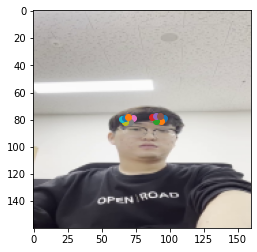

In [632]:
plt.imshow(img_temp[0])
pred = model.predict(img_temp)[0]
for i in range(0, 24, 2):
    plt.scatter(pred[i], 160-pred[i+1])
dist = sleep_detection(pred)
print(dist)